<a href="https://colab.research.google.com/github/nishantasmit/Flood_Prediction_Model/blob/main/FINALREGRESSOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor


In [4]:
class XGBRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, **params):
        self.params = params
        self.model = None

    def fit(self, X, y):
        self.model = xgb.XGBRegressor(**self.params)
        self.model.fit(X, y)
        return self

    def predict(self, X):
        if self.model is None:
            raise ValueError("Model has not been fitted yet!")
        return self.model.predict(X)

    def get_params(self, deep=True):
        return self.params

    def set_params(self, **params):
        self.params.update(params)
        return self


data = pd.read_csv("newflood.csv")
df = pd.DataFrame(data)

In [5]:
print(df.columns)

Index(['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'FloodProbability'],
      dtype='object')


In [6]:
print(df.describe())

       MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
count      50000.000000        50000.000000      50000.00000   50000.000000   
mean           4.991480            4.984100          5.01594       5.008480   
std            2.236834            2.246488          2.23131       2.222743   
min            0.000000            0.000000          0.00000       0.000000   
25%            3.000000            3.000000          3.00000       3.000000   
50%            5.000000            5.000000          5.00000       5.000000   
75%            6.000000            6.000000          6.00000       6.000000   
max           16.000000           18.000000         16.00000      17.000000   

       Urbanization  ClimateChange  DamsQuality     Siltation  \
count  50000.000000   50000.000000  50000.00000  50000.000000   
mean       4.989060       4.988340      5.01536      4.988600   
std        2.243159       2.226761      2.24500      2.232642   
min        0.000000       0.

In [7]:
print(df.head())

   MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
0                 3                   8                6              6   
1                 8                   4                5              7   
2                 3                  10                4              1   
3                 4                   4                2              7   
4                 3                   7                5              2   

   Urbanization  ClimateChange  DamsQuality  Siltation  AgriculturalPractices  \
0             4              4            6          2                      3   
1             7              9            1          5                      5   
2             7              5            4          7                      4   
3             3              4            1          4                      6   
4             5              8            5          2                      7   

   Encroachments  ...  DrainageSystems  CoastalVulnerability  

In [8]:
print(df.tail())

       MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
49995                 3                   7                4              7   
49996                 3                  10                3              8   
49997                 4                   4                5              7   
49998                 4                   5                4              4   
49999                 4                   5                6              3   

       Urbanization  ClimateChange  DamsQuality  Siltation  \
49995             5              9            4          6   
49996             3              3            4          4   
49997             2              1            4          5   
49998             6              3           10          2   
49999             5              6            5          4   

       AgriculturalPractices  Encroachments  ...  DrainageSystems  \
49995                     10              4  ...                7   
49996         

In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   MonsoonIntensity                 50000 non-null  int64  
 1   TopographyDrainage               50000 non-null  int64  
 2   RiverManagement                  50000 non-null  int64  
 3   Deforestation                    50000 non-null  int64  
 4   Urbanization                     50000 non-null  int64  
 5   ClimateChange                    50000 non-null  int64  
 6   DamsQuality                      50000 non-null  int64  
 7   Siltation                        50000 non-null  int64  
 8   AgriculturalPractices            50000 non-null  int64  
 9   Encroachments                    50000 non-null  int64  
 10  IneffectiveDisasterPreparedness  50000 non-null  int64  
 11  DrainageSystems                  50000 non-null  int64  
 12  CoastalVulnerabili

In [10]:
missing_data = df.isnull().sum()
if missing_data.sum() > 0:
    df = df.dropna()

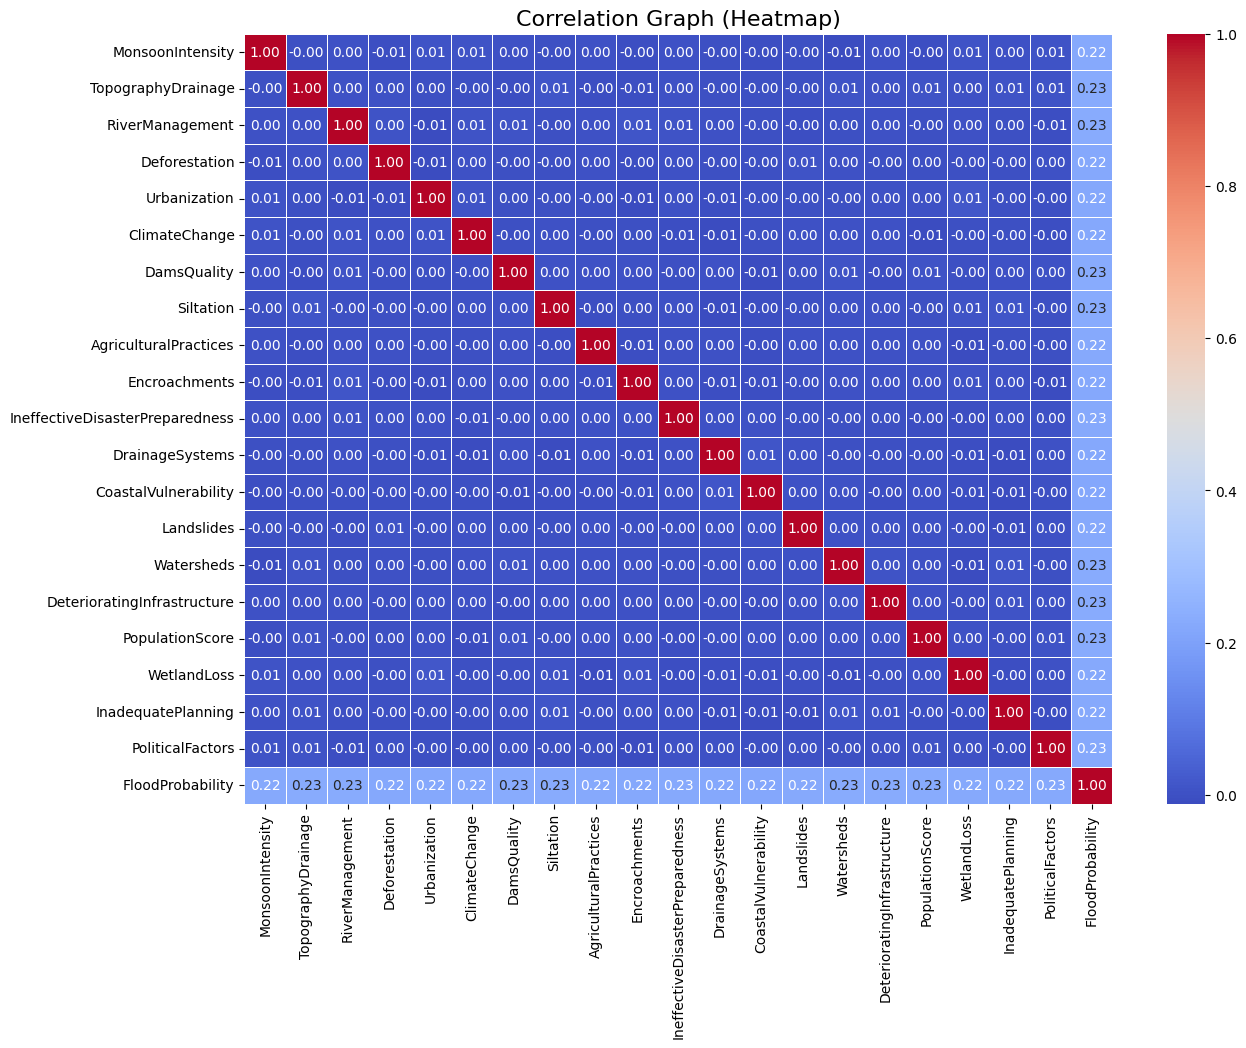

In [11]:
correlation_matrix = df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Graph (Heatmap)', fontsize=16)
plt.show()

In [12]:
X = df.drop('FloodProbability', axis=1)
y = df['FloodProbability']

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42)

In [15]:
random_state = 42

xgb_model = XGBRegressorWrapper(random_state=random_state)

regressor = [
    KNeighborsRegressor(),
    GradientBoostingRegressor(random_state=random_state),
    xgb_model,
    LGBMRegressor(random_state=random_state,verbose=-1)
]

# KNeighborsRegressor Parameter Grid
knn_param_grid = {
    "n_neighbors": [3, 5, 7],
    "weights": ["uniform", "distance"],
    "p": [1, 2]
}

# GradientBoostingRegressor Parameter Grid
gbr_param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 3]
}

# XGBRegressor Parameter Grid

xgb_param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# LGBMRegressor Parameter Grid
lgbm_param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "num_leaves": [31, 50],
    "max_depth": [-1, 10, 20]
}

regressor_param = [knn_param_grid,gbr_param_grid,xgb_param_grid,lgbm_param_grid]

In [16]:
# Train all models and evaluate performance
results = []

for i, model in enumerate(regressor):
    try:
        print(f"\nTraining {model.__class__.__name__}...\n")

        # Hyperparameter tuning
        clf = RandomizedSearchCV(
            model,
            param_distributions=regressor_param[i],
            n_iter=20,
            cv=3,
            scoring="r2",
            n_jobs=-1,
            verbose=1,
            random_state=random_state
        )
        clf.fit(X_train, y_train)

        # Best estimator after tuning
        best_model = clf.best_estimator_
        print(f"Best parameters for {model.__class__.__name__}: {clf.best_params_}")

        # Predictions
        y_pred = best_model.predict(X_test)

        # Compute regression metrics
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)

        # Store results
        results.append({
            "Model": model.__class__.__name__,
            "R² Score": r2,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse
        })

    except Exception as e:
        print(f"Error with {model.__class__.__name__}: {e}")



Training KNeighborsRegressor...

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for KNeighborsRegressor: {'weights': 'distance', 'p': 2, 'n_neighbors': 7}

Training GradientBoostingRegressor...

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters for GradientBoostingRegressor: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.2}

Training XGBRegressorWrapper...

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters for XGBRegressorWrapper: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 1.0}

Training LGBMRegressor...

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best parameters for LGBMRegressor: {'num_leaves': 50, 'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.1}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [17]:
# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("\nFinal Regression Metrics for All Models:")
print(results_df)



Final Regression Metrics for All Models:
                       Model  R² Score       MAE       MSE      RMSE
0        KNeighborsRegressor  0.784627  0.018292  0.000546  0.023360
1  GradientBoostingRegressor  0.972805  0.006566  0.000069  0.008301
2        XGBRegressorWrapper  0.973470  0.006471  0.000067  0.008199
3              LGBMRegressor  0.965043  0.007340  0.000089  0.009411


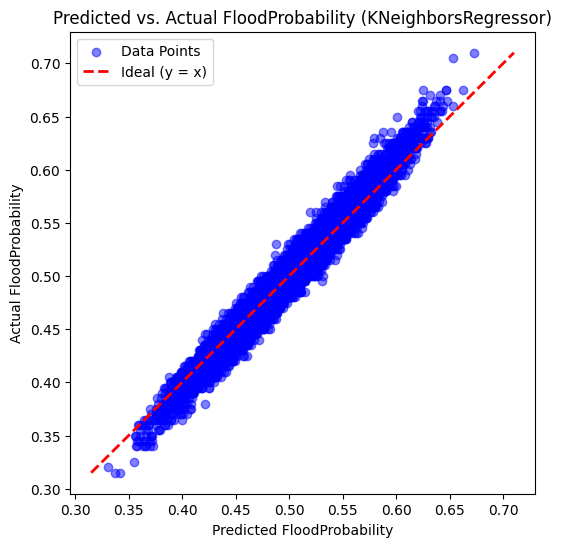

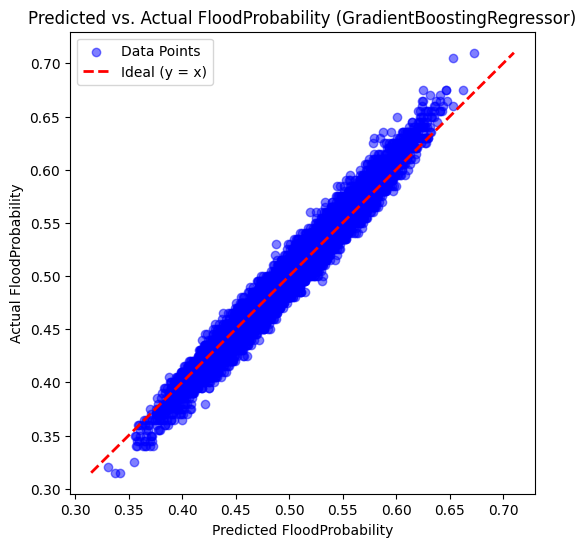

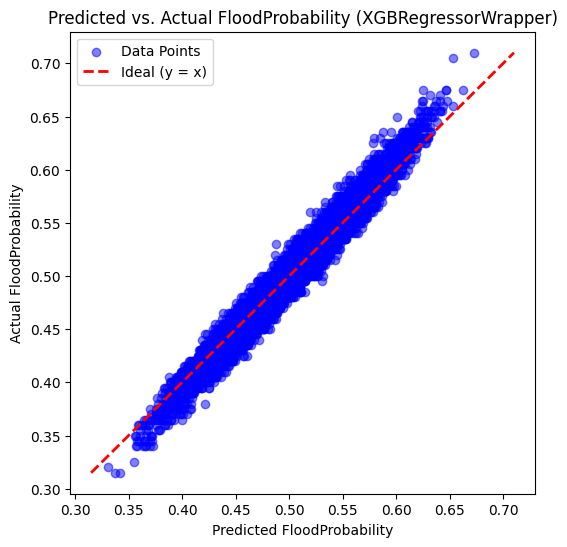

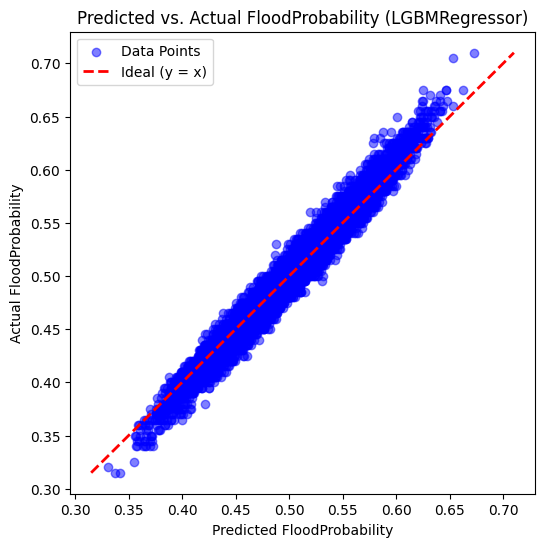

In [18]:
for i, model in enumerate(regressor):
    try:
        best_model = results_df.iloc[i]["Model"]

        # Scatter plot for each model
        plt.figure(figsize=(6, 6))
        plt.scatter(y_pred, y_test, alpha=0.5, label="Data Points", color="blue")
        min_val = min(np.min(y_pred), np.min(y_test))
        max_val = max(np.max(y_pred), np.max(y_test))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label="Ideal (y = x)")
        plt.xlabel("Predicted FloodProbability")
        plt.ylabel("Actual FloodProbability")
        plt.title(f"Predicted vs. Actual FloodProbability ({best_model})")
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"Error in visualization for {model.__class__.__name__}: {e}")


/tmp/ipython-input-19-184589379.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=df, palette=colors, ax=ax, edgecolor="black", alpha=0.8)
/tmp/ipython-input-19-184589379.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df["Model"], rotation=15, ha="right", fontsize=10)
/tmp/ipython-input-19-184589379.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=df, palette=colors, ax=ax, edgecolor="black", alpha=0.8)
/tmp/ipython-input-19-184589379.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e.

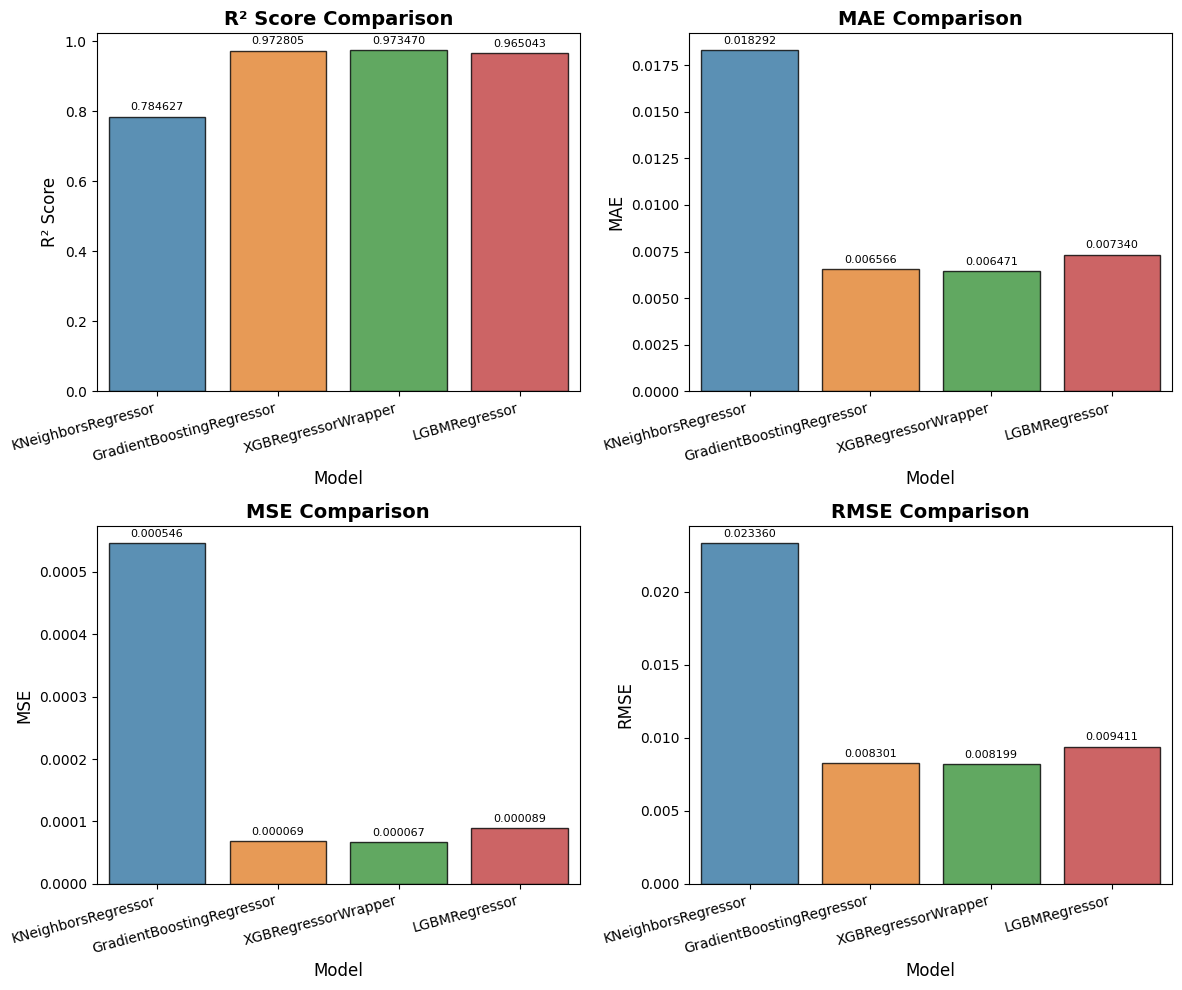

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create DataFrame with given regression metrics
data = {
    "Model": ["KNeighborsRegressor", "GradientBoostingRegressor", "XGBRegressorWrapper", "LGBMRegressor"],
    "R² Score": [0.784627, 0.972805, 0.973470, 0.965043],
    "MAE": [0.018292, 0.006566, 0.006471, 0.007340],
    "MSE": [0.000546, 0.000069, 0.000067, 0.000089],
    "RMSE": [0.023360, 0.008301, 0.008199, 0.009411]
}

df = pd.DataFrame(data)

# Define plot settings
metrics = ["R² Score", "MAE", "MSE", "RMSE"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # Custom colors

# Create subplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(x="Model", y=metric, data=df, palette=colors, ax=ax, edgecolor="black", alpha=0.8)
    ax.set_title(f"{metric} Comparison", fontsize=14, fontweight="bold")
    ax.set_xlabel("Model", fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_xticklabels(df["Model"], rotation=15, ha="right", fontsize=10)

    # Display values on bars
    for container in ax.containers:
        ax.bar_label(container, fmt="%.6f", fontsize=8, padding=3, rotation=0)

# Adjust layout
plt.tight_layout()
plt.show()
